In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os

from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

from sklearn.ensemble import RandomForestClassifier


# Load Data

First step is to ingest all the data we have available and merge them into a flattened datastructure containing all measurements. Indexes are ignored and rewritten to allow all readings to be added to the DF:

In [2]:
# parse the labels.csv
labels = pd.read_csv('labels.csv', index_col=0)

# grab filenames from the data directory
filenames = os.listdir('data')

dataframes = []

# parse and concatenate all csv files into df
for filename in filenames:
  if filename.endswith('.csv'):
    batch = pd.read_csv(os.path.join('data',filename), index_col=0)
    batch['batch'] = int(filename.replace('.csv', ''))
    dataframes.append(batch)

df = pd.concat(dataframes, ignore_index=True)

# print(df[:10])


In [3]:
# add label column (if it is not already available)
if (not 'label' in df.columns):
  df = df.merge(labels, left_on=["batch"], right_on=["id"])

def time_to_float(inputstr):
  hours, minutes, seconds = map(float, inputstr.split(':'))

  # return hours * 3600 + minutes * 60 + seconds
  # this is sufficient because hours should always be 0
  return minutes * 60 + seconds

if (not df['zeit'].dtype == 'category'):
  df['label'] = df['label'].astype('category')
if (not df['zeit'].dtype == 'float64'):
  df['zeit'] = df['zeit'].apply(time_to_float)

# print(df[:10])
# print(df['label'].value_counts())
# print(df['sensorid'].value_counts())


# Test Data Preprocessing

In [4]:
X = df[['zeit','messwert','sensorid']]
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# print(X_train[:10])
# print(y_train[:10])


# Modelling

In [5]:
rf_clf = RandomForestClassifier(max_depth=32, n_jobs=12, max_features=3, random_state=42)
# rf_clf = make_pipeline(StandardScaler(), RandomForestClassifier(max_depth=32, n_jobs=8, max_features=3, random_state=42))
rf_clf.fit(X_train, y_train)


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:   40.6s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:  2.0min finished


RandomForestClassifier(max_depth=32, max_features=3, n_jobs=12, random_state=42,
                       verbose=True)

# Evaluation

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    1.8s


0.4229809761200323


[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    5.9s finished


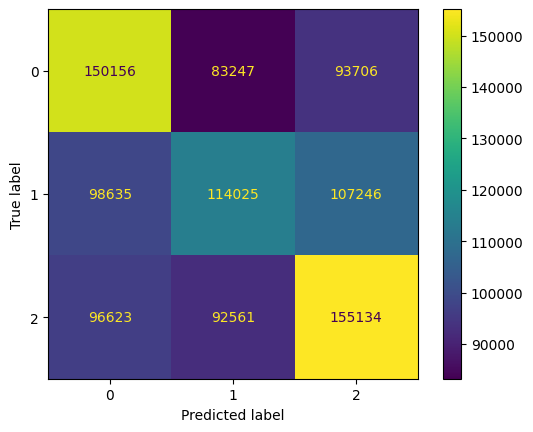

In [6]:
rf_y_pred = rf_clf.predict(X_test)

rf_acc = accuracy_score(y_test, rf_y_pred)
print(rf_acc)

rf_cm = confusion_matrix(y_test, rf_y_pred, labels=rf_clf.classes_)
rf_disp = ConfusionMatrixDisplay(confusion_matrix=rf_cm, display_labels=rf_clf.classes_)
rf_disp.plot()
plt.show()
